#  <div align='center'>第8章 非参数统计(3)</div>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.stats.anova as sma
import statsmodels.formula.api as smf
import statsmodels.stats.api as smt
import statsmodels.api as sm
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

-----

## 8.6 秩相关与分位数回归
本节内容主要包括基于秩的两变量相关关系和多变量之间的协同关系分析；中位数回归与分位数回归方法。

### 8.6.1 Spearman秩相关检验
- #### 示例：
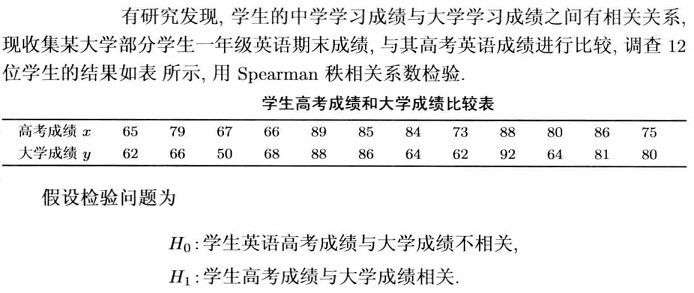

In [2]:
'''
当统计量T大于显著性水平为0.01，自由度为n-2的t值时，拒绝原假设，接受备择假设。
'''
x=np.array([65,79,67,66,89,85,84,73,88,80,86,75])
y=np.array([62,66,50,68,88,86,64,62,92,64,81,80])
n=len(x)
Ri=st.rankdata(x)
Qi=st.rankdata(y)
rs=1-6/(n*(n**2-1))*np.sum((Ri-Qi)**2)



print('秩相关系数为：',rs)
T=rs*((n-2)/(1-rs**2))**0.5

###显著性水平alpha=0.01,自由度为10，即n-2
t=st.t.ppf(0.99,10)
print('\nT统计量：',T,'，显著性水平为0.01的t值：',t)

###计算T的p值，由于是双边检验，所以需要对生存函数的值乘2
pvalue=2*st.t.sf(T,10)
print('\nT统计量p值为：',pvalue)

###Spearman秩相关检验
#Spearman秩相关检验
st.spearmanr(x,y)

秩相关系数为： 0.7727272727272727

T统计量： 3.8497419160916255 ，显著性水平为0.01的t值： 2.763769457447889

T统计量p值为： 0.0032135750357506292


SpearmanrResult(correlation=0.7719345764047542, pvalue=0.003265288619878138)

### 8.6.2 Kendall $\tau$相关检验


- #### 示例：
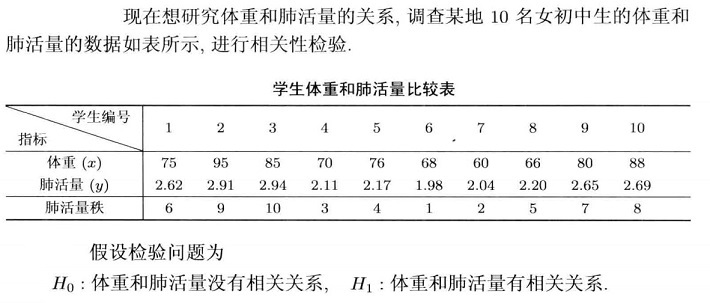


In [3]:
'''
Kendall tau相关检验的重点在于协同量Nc和不协同量Nd的计算。
tau值显著大于0，即学生体重与肺活量存在相关性，而且是正相关。
'''
w=np.array([75,95,85,70,76,68,60,66,80,88])
l=np.array([2.62,2.91,2.94,2.11,2.17,1.98,2.04,2.20,2.65,2.69])
wr=st.rankdata(w)
lr=st.rankdata(l)

n=len(w)
signs=[]
###计算kendall相关系数tau值
for i in range(n):
    for j in range(i,n):
        signs.append(np.sign((wr[i]-wr[j])*(lr[i]-lr[j])))
tau=2/(n*(n-1))*np.sum(signs)
print('tau值：',tau)

###使用scipy的kendalltau函数进行相关检验
st.kendalltau(w,l)

tau值： 0.6888888888888889


KendalltauResult(correlation=0.6888888888888888, pvalue=0.00468694885361552)

In [4]:
###协同数对和不协同数对
si=np.array(signs)
np.sum(si>0),np.sum(si<0)

(38, 7)

In [5]:
###Kendall tau显著性检验的p值计算，稍显复杂
#在秩无结点的情况下，该代码来自kendalltau函数
from scipy.special import factorial
##不协同数对个数为7，协同数对为38
new = [0.0]*(7+1)
new[0] = 1.0
new[1] = 1.0
##样本数为10
for j in range(3,10+1):
    old = new[:]
    for k in range(1,min(j,7+1)):
        new[k] += new[k-1]
    for k in range(j,7+1):
        new[k] += new[k-1] - old[k-j]

pvalue = 2.0*np.sum(new)/factorial(10)
pvalue

0.00468694885361552

- #### $\tau$的分布
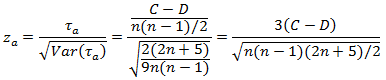

In [6]:
###通过z分布逼近进行检验
#检验结果与kendalltau函数一致，即拒绝原假设，体重与肺活量存在关联关系
z_alpha=3*(38-7)/(n*(n-1)*(2*n+5)/2)**0.5
z_alpha,2*st.norm.sf(z_alpha)

(2.7727242920997393, 0.005558919627070556)

### 8.6.3 多变量Kendall协和系数检验
-
- #### 示例：
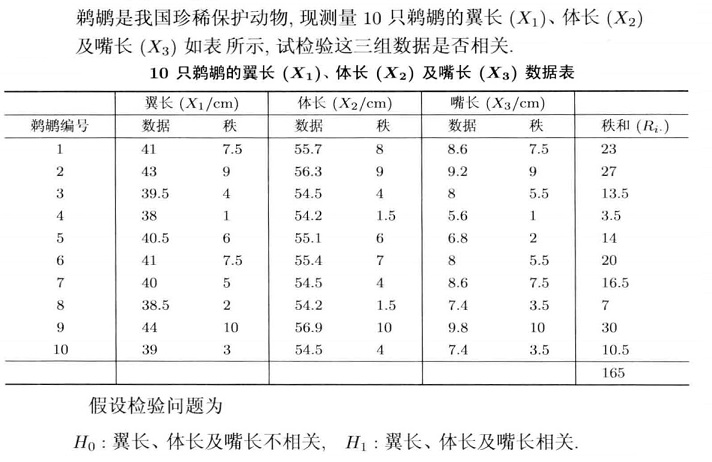


In [7]:
'''
Kendall协和系数检验的统计量的计算
'''
###原始数据
X1=np.array([41,43,39.5,38,40.5,41,40,38.5,44,39])
X2=np.array([55.7,56.3,54.5,54.2,55.1,55.4,54.5,54.2,56.9,54.5])
X3=np.array([8.6,9.2,8,5.6,6.8,8,8.6,7.4,9.8,7.4])

###3组数据的秩
r1=st.rankdata(X1)
r2=st.rankdata(X2)
r3=st.rankdata(X3)

###计算T值
from collections import Counter
T=[]
###将3个秩中的结点及其结长取出来，计算r^3-r公式
#结长大于1的结点才进行计算并保存。
for c in (Counter(r1),Counter(r2),Counter(r3)):
    for d in c.values():
        if d>1:#结长大于1的结点
            T.append(d**3-d)
T=np.sum(T)

### 计算Wc值
k=3
n=len(X1)
r=np.c_[r1,r2,r3]
###Ri.秩和，3组数据对应秩之和
Ri=np.sum(r,1)
Wc=(12*np.sum(Ri**2)-3*k**2*n*(n+1)**2)/(k**2*(n**3-n)-k*T)

###待检验的卡方值
W=k*(n-1)*Wc
print('卡方值：',W, '，显著性水平0.05的卡方值：',st.chi2.ppf(0.95,n-1),
      '，卡方检验的p值：',st.chi2.sf(W,n-1))

卡方值： 24.35185185185185 ，显著性水平0.05的卡方值： 16.918977604620448 ，卡方检验的p值： 0.003778366910230634


### 8.6.4 $Kappa$ 一致性检验


- #### 示例：
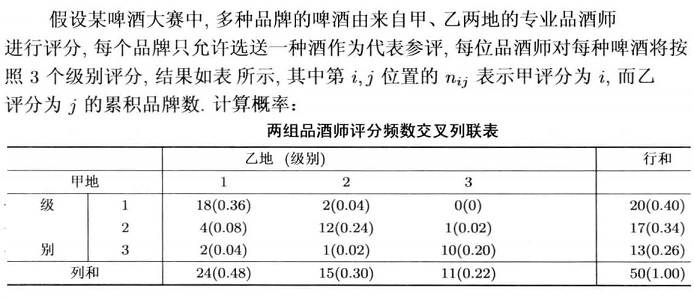

In [8]:
'''
Kappa一致性检验。计算结果表明，正态逼近值Z=6.8787，大于显著性水平0.05的Z值，
表明拒绝原假设，接受备择假设。
检验的p值远小于0.05，同样是拒绝原假设。
'''
###原始评分频数
scores=np.array([18,2,0,4,12,1,2,1,10]).reshape(3,3)
###行频数和
si=scores.sum(1)
###列频数和
sj=scores.sum(0)
###总频数和
n=scores.sum()
###单元概率
p_ij=scores/n
###行概率和
p_i=p_ij.sum(1)
###列概率和
p_j=p_ij.sum(0)
###类别概率和，即pii之和=p11+p22+p33
P0=np.diag(p_ij).sum()
###行概率和列概率和之积再求和
Pe=np.sum(p_i*p_j)
###Kappa统计量，多次判断结果一致性度量
K=(P0-Pe)/(1-Pe)
###Kappa统计量的标准差
std_k=(1/(n*(1-Pe)**2)*(Pe+Pe**2-np.sum(p_i*p_j*(p_i+p_j))))**0.5
###正态逼近值
Z=K/std_k
print('K值：',K,'\nZ值：',Z,'\n显著性水平0.05的Z值：',st.norm.ppf(0.975),
      '\n显著性检验的p值：',st.norm.sf(Z))

K值： 0.6917385943279902 
Z值： 6.878689011802013 
显著性水平0.05的Z值： 1.959963984540054 
显著性检验的p值： 3.0202932708548276e-12


### 8.6.5 中位数回归系数估计方法



- #### 示例：
使用南非心脏病数据中的ldl（低密度脂蛋白）和adiposity（肥胖指标）2个属性的数据进行回归分析，以ldl作为自变量，adiposity作为因变量。

In [9]:
saheart=pd.read_csv('e:\\data\\saheart.csv')
saheart.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [10]:
'''
Brown-Mood方法进行参数估计。
'''
X=saheart.ldl
Y=saheart.adiposity
medX=np.median(X)#X自变量的中位数
medX1=np.median(X[X<=medX])#X中位数之前半段数据的中位数
medX2=np.median(X[X>medX])#X中位数之后半段数据的中位数

###根据X中位数的定位Y的前、后半段，然后分别求中位数
medY1=np.median(Y[X<=medX])
medY2=np.median(Y[X>medX])

###求解回归系数和截距
beta=(medY2-medY1)/(medX2-medX1)
alpha=np.median(Y-X*beta)
print('Brown-Mood回归系数估计：%0.4f+%0.4f*X'%(alpha,beta))

'''
最小二乘法进行线性回归。可以使用Statsmodels的ols（或OLS）。
'''
formula='y~x'
results=smf.ols(formula,data={'y':Y,'x':X}).fit()
alpha1=results.params[0]
beta1=results.params[1]
print('最小二乘回归参数估计：%0.4f+%0.4f*X'%(alpha1,beta1))

Brown-Mood回归系数估计：11.5552+2.9523*X
最小二乘回归参数估计：17.5626+1.6548*X


- #### (2) Theil方法


In [11]:
'''
Theil方法估计回归系数。
'''
n=len(X)
s_ij=[]
###迭代求解斜率集合
for i in np.arange(0,n):
    for j in np.arange(i+1,n):
        if (X[j]-X[i])!=0:
            s_ij.append((Y[j]-Y[i])/(X[j]-X[i]))
        
beta2=np.median(s_ij)
alpha2=np.median(Y-beta2*X)

In [12]:
###手工编码和theilslopes函数计算的斜率一致，但是截距不同。
beta2,alpha2,st.theilslopes(Y,X)[0:2]

(2.0275423728813564,
 16.029110169491524,
 (2.0275423728813564, 17.315466101694916))

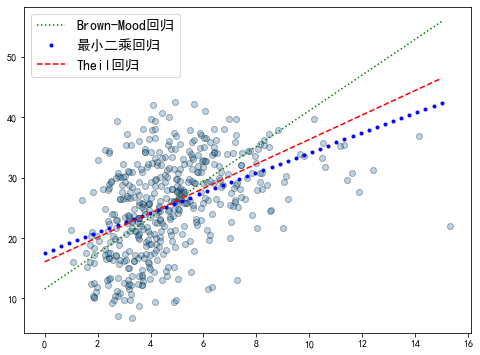

In [13]:
'''
从图中可以看出Brown-Mood和Theil回归更能符合数据的主体趋势。
'''
plt.figure(figsize=(8,6))
###原始样本数据的散点图
plt.scatter(X,Y,facecolor=None,edgecolor='k',alpha=0.3)
x=np.linspace(0,15,50)##自变量测试数据
y1=alpha+beta*x##Brown-Mood回归
y2=alpha1+beta1*x##最小二乘回归
y3=alpha2+beta2*x##Theil回归

plt.plot(x,y1,'g:',label='Brown-Mood回归')
plt.plot(x,y2,'b.',label='最小二乘回归')
plt.plot(x,y3,'r--',label='Theil回归')

plt.legend(fontsize=14)
plt.show()

- #### 回归系数检验
##### Brown-Mood检验：


In [14]:
'''
Brown-Mood检验
'''
###此处使用Brown-Mood回归方程计算Y的回归值
Y_bm=alpha+beta*X
#Y_bm=alpha1+beta1*X #使用最小二乘估计的回归方程
#Y_bm=alpha2+beta2*X #使用Theil方法估计的回归方程

###n1的计算
a1 = np.where(X<medX)[0]
b1 = np.where(Y>Y_bm)[0]
n1=0
for i in a1:
    if i in b1:
        n1+=1
        
###n2的计算
a2 = np.where(X>medX)[0]
b2 = np.where(Y<Y_bm)[0]
n2=0
for j in a2:
    if j in b2:
        n2+=1

###BM统计量
BM=(8/n)*((n1-n/4)**2+(n2-n/4)**2)
print('Brown-Mood检验统计量：',BM,'\nBM检验p值：',st.chi2.sf(BM,2))

Brown-Mood检验统计量： 4.199134199134199 
BM检验p值： 0.12250945116977789


##### Theil检验
此检验方法是使用Theil回归系数beta2乘以X，然后使用Y减去该值得到的残差，然后与X进行$Kendall$  $\tau$检验。原假设为：$H_0:\beta=\beta_0$

In [15]:
'''
检验结果p值大于0.05，表明不能拒绝beta=beta0的原假设。
该方法不大适合Brown-Mood和最小二乘估计回归系数的检验，大家可以试试。
'''
res=Y-beta2*X
st.kendalltau(X,res)

KendalltauResult(correlation=0.0, pvalue=1.0)

### 8.6.6 线性分位回归模型


In [16]:
'''
使用engel数据，数据包括235个比利时家庭的年家庭收入和用于食品支出的费用进行观察。
本例使用等分位回归，tau的取值从0.1到0.9，间隔为0.1
'''
engel=pd.read_csv('e:\\data\engel.csv')
engel.head()

,income,foodexp
0,420.157651,255.839425
1,541.411707,310.958667
2,901.157457,485.680014
3,639.080229,402.997356
4,750.875606,495.560775


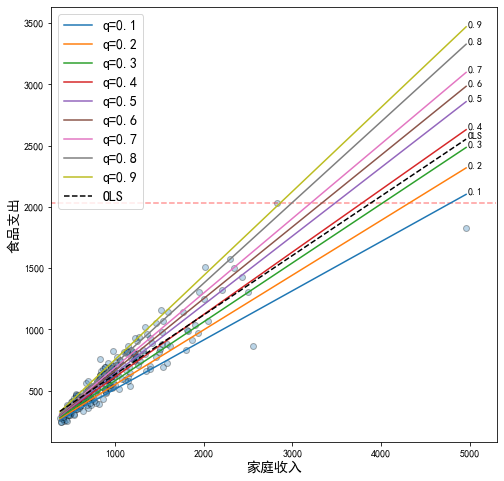

In [17]:
engel=pd.read_csv('e:\\data\\engel.csv')
plt.figure(figsize=(8,8))
plt.scatter(engel.income,engel.foodexp,edgecolor='k',alpha=0.3)
params=[]
for i in np.arange(0.1,1.0,0.1):
    ###tau取值从0.1到0.9分别进行分位数回归。
    #通过设置fit函数的q参数调用不同百分位的回归拟合。
    results=smf.quantreg('foodexp~income',data=engel).fit(q=i)
    params.append(results.params)
plt.xlabel('家庭收入',size=14)
plt.ylabel('食品支出',size=14)

###采用最小二乘法的线性回归
results2=smf.ols('foodexp~income',data=engel).fit()
ols_parm=results2.params

X=np.linspace(np.min(engel.income),np.max(engel.income),30)
quant=np.round(np.arange(0.1,1.0,0.1),1)

###不同分位数的回归直线
for j in range(len(params)):
    pa=params[j]
    plt.plot(X,pa[0]+X*pa[1],label=('q='+str(quant[j])))
    plt.text(np.max(X)+20,pa[0]+np.max(X)*pa[1],str(quant[j]))

###普通最小二乘的回归直线
plt.plot(X,ols_parm[0]+X*ols_parm[1],'k--',label='OLS')
plt.text(np.max(X)+20,ols_parm[0]+np.max(X)*ols_parm[1],'OLS')

###沿Y轴最大值画一条水平直线作为参考
plt.hlines(y=np.max(engel.foodexp)+1,xmin=0,xmax=5300,
           colors='r',linestyles='dashed',alpha=0.4)
plt.xlim(np.min(X)-100,5310)
plt.legend(fontsize=14)
plt.show()

---------------